In [1]:
import shap
import lime
import torch
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from lime import lime_tabular
from torch_geometric.data import Data
from sklearn.model_selection import KFold
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.explain import GNNExplainer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.loader import DataLoader as GeometricDataLoader
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Define Advanced GNN Model
class AdvancedGNNModel(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, dropout):
        super(AdvancedGNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GATConv(64, 128, heads = 4, concat = True)
        self.conv3 = GCNConv(128 * 4, 64)  # GAT outputs heads*hidden channels
        self.fc1 = torch.nn.Linear(64, 32)
        self.fc2 = torch.nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(p = dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def visualize_graph(edge_index, num_nodes = 12):
    """
    Visualize a subgraph consisting of 'num_nodes' nodes and their corresponding edges.
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    for i, j in edge_index.t().tolist():
        if i < num_nodes and j < num_nodes:
            G.add_edge(i, j)
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels = True, node_color = 'skyblue', node_size = 700, edge_color = 'k')
    plt.title(f'Subgraph with {num_nodes} Nodes')
    plt.show()

def create_custom_edge_index():
    """
    Create custom edge index based on edge list.
    """
    custom_edges = [
        (0, 10), (1, 10), (2, 5), (2, 7), (2, 10), (2, 11),
        (3, 10), (4, 10), (5, 8), (6, 10), (7, 8), (8, 9), (8, 11)
    ]
    edges = []
    for edge in custom_edges:
        i, j = edge
        edges.append([i, j])
        edges.append([j, i])  # Undirected graph
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create Data objects for training and testing sets
def create_graph_data(features, labels):
    edge_index = create_custom_edge_index()  # Custom edge index for all graphs
    data = Data(x = features, edge_index = edge_index, y = labels)
    return data

In [3]:
# Load and preprocess the data
InputData = pd.read_csv('Data/Dataset_spine_clean.csv')
node_features = torch.tensor(InputData.iloc[:, 1:13].values, dtype=torch.float)
labels_string = InputData.iloc[:, 13].values
labels = torch.tensor([1 if label == 'Normal' else 0 for label in labels_string], dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(node_features, labels, test_size=0.2, random_state=42)

train_data = create_graph_data(X_train, y_train)
test_data = create_graph_data(X_test, y_test)

# Create DataLoader instances
train_loader = GeometricDataLoader([train_data], batch_size=1, shuffle=True)
test_loader = GeometricDataLoader([test_data], batch_size=1, shuffle=False)

In [4]:
# Initialize the model, loss function, and optimizer
model = AdvancedGNNModel(num_node_features = 12, num_classes = 2, dropout = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002, weight_decay = 1e-6)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)  # Learning rate scheduler

# Train the model
epochs = 1000
loss_values = []
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
        optimizer.step()
    ##scheduler.step()  # Update learning rate
        loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 0.8482
Epoch [2/1000], Loss: 1.9208
Epoch [3/1000], Loss: 1.2664
Epoch [4/1000], Loss: 0.5903
Epoch [5/1000], Loss: 0.9491
Epoch [6/1000], Loss: 0.9427
Epoch [7/1000], Loss: 0.7637
Epoch [8/1000], Loss: 0.6069
Epoch [9/1000], Loss: 0.5753
Epoch [10/1000], Loss: 0.5666
Epoch [11/1000], Loss: 0.4961
Epoch [12/1000], Loss: 0.5057
Epoch [13/1000], Loss: 0.5126
Epoch [14/1000], Loss: 0.4698
Epoch [15/1000], Loss: 0.4491
Epoch [16/1000], Loss: 0.4421
Epoch [17/1000], Loss: 0.4342
Epoch [18/1000], Loss: 0.4508
Epoch [19/1000], Loss: 0.4408
Epoch [20/1000], Loss: 0.4690
Epoch [21/1000], Loss: 0.4365
Epoch [22/1000], Loss: 0.4247
Epoch [23/1000], Loss: 0.4129
Epoch [24/1000], Loss: 0.4200
Epoch [25/1000], Loss: 0.3955
Epoch [26/1000], Loss: 0.4003
Epoch [27/1000], Loss: 0.4105
Epoch [28/1000], Loss: 0.3896
Epoch [29/1000], Loss: 0.3808
Epoch [30/1000], Loss: 0.3776
Epoch [31/1000], Loss: 0.3775
Epoch [32/1000], Loss: 0.3721
Epoch [33/1000], Loss: 0.4015
Epoch [34/1000], Lo

In [5]:
# Evaluate the model
model.eval()
true_labels = []
predictions = []
probs = []

with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        _, pred = out.max(dim=1)
        predictions.extend(pred.tolist())
        true_labels.extend(batch.y.tolist())
        probs.extend(F.softmax(out, dim = 1)[:, 1].tolist())

# Convert lists to numpy arrays for metric calculation
true_labels = np.array(true_labels)
predictions = np.array(predictions)
probs = np.array(probs)

# Calculate metrics
test_accuracy = accuracy_score(true_labels, predictions)
test_precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
test_recall = recall_score(true_labels, predictions, average='macro', zero_division=0)
test_f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

Test Accuracy: 0.7581
Test Precision: 0.7052
Test Recall: 0.6982
Test F1 Score: 0.7014


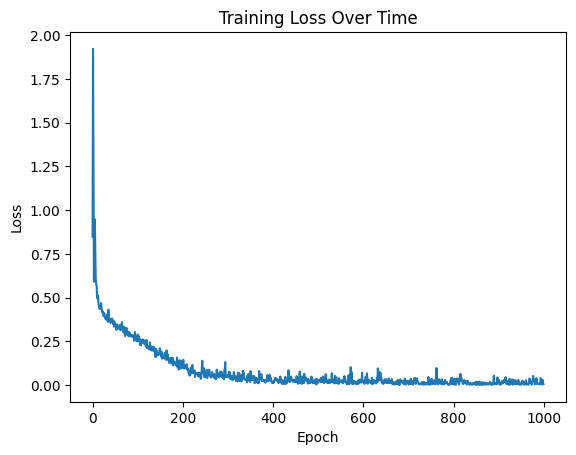

In [6]:
# Plot the loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

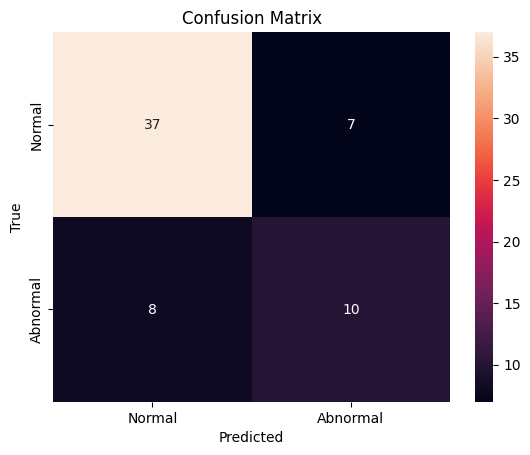

In [7]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot = True, fmt='d', xticklabels = ['Normal', 'Abnormal'], yticklabels = ['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

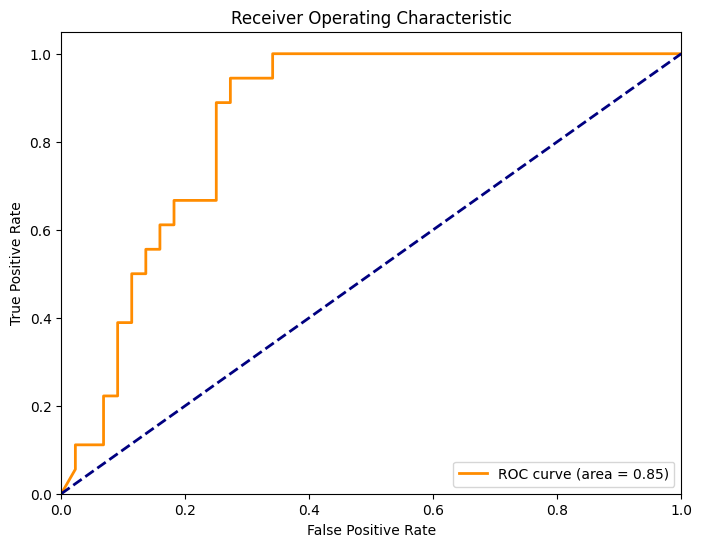

In [8]:
# Plot ROC curve and calculate AUC
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

CROSS VALIDATION

Fold 1/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 57
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 62
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 77
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 90
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 68
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 40
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 79
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 65
(9) Training with params: weight_decay = 1e-06, learning_r

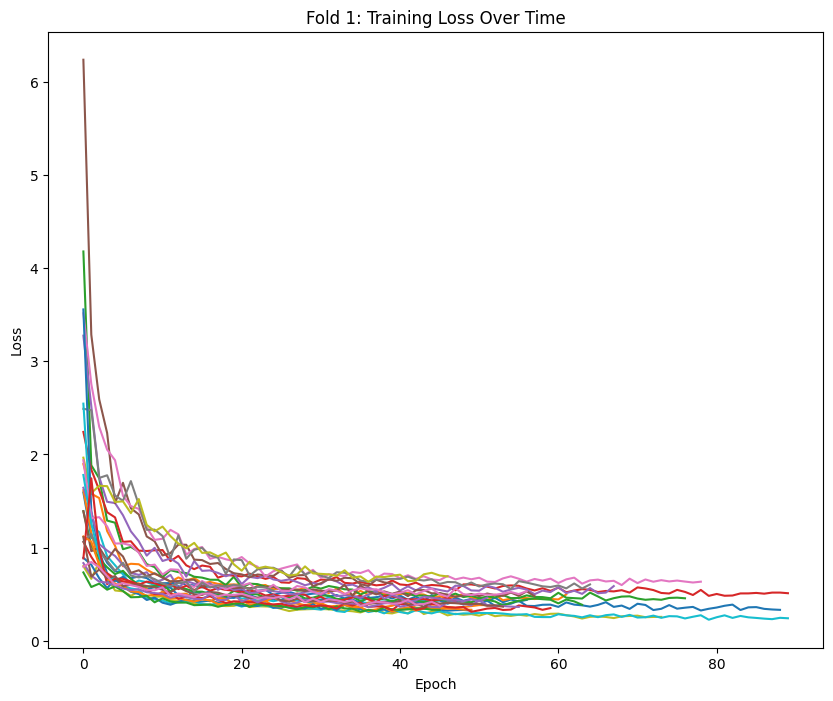

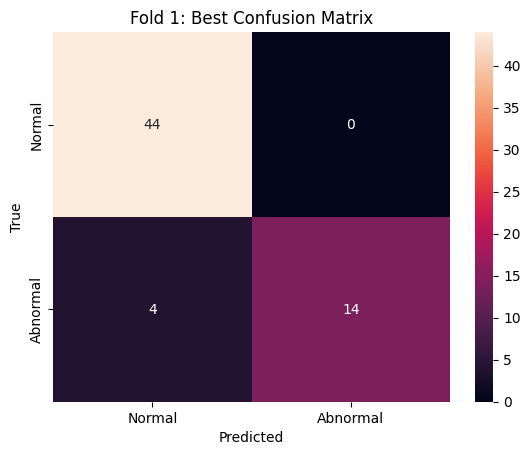

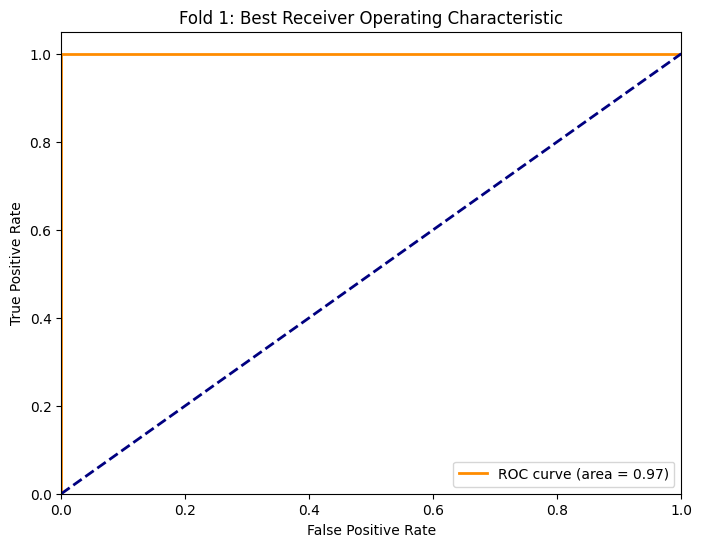

Fold 2/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 71
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 67
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 100
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 66
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 85
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 80
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 60
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 55
(9) Training with params: weight_decay = 1e-06, learning_

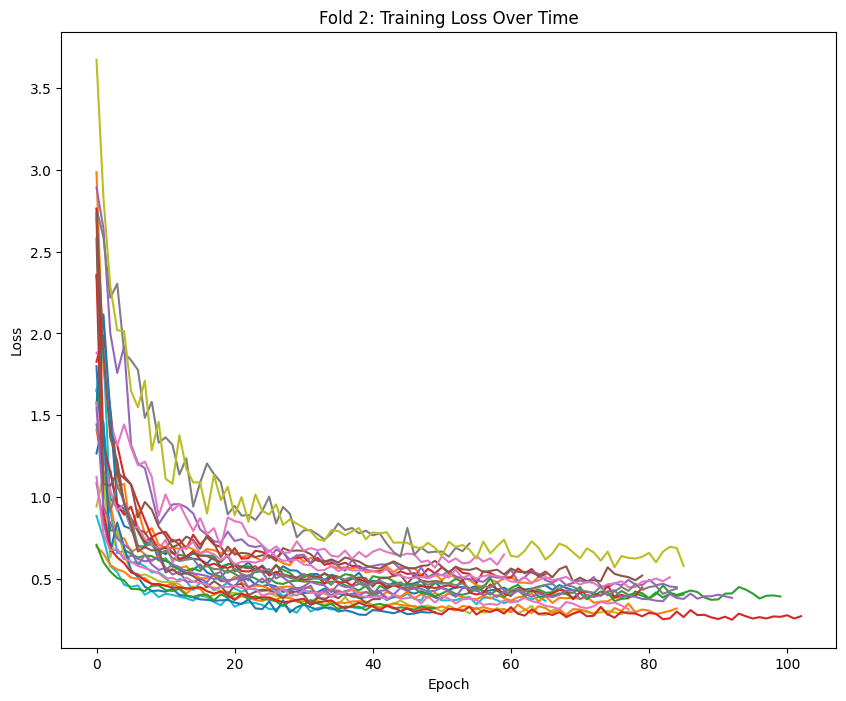

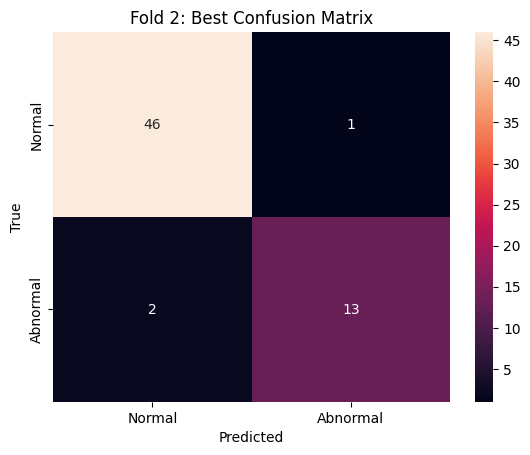

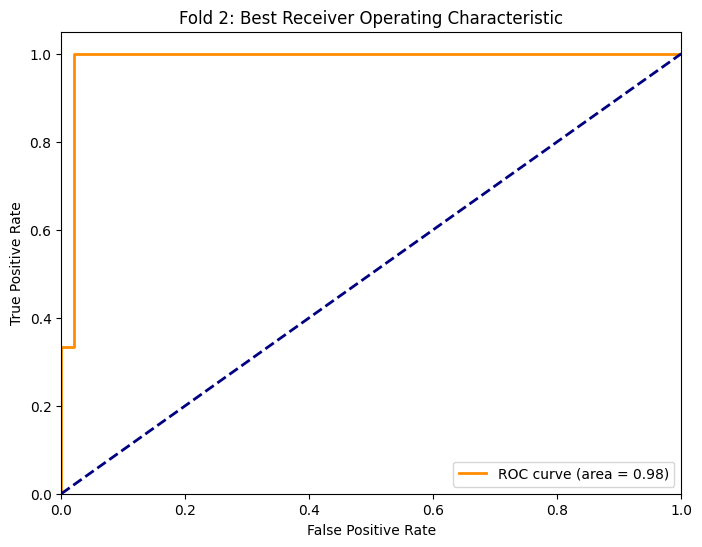

Fold 3/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 77
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 18
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 69
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 79
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 75
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 43
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 71
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 43
(9) Training with params: weight_decay = 1e-06, learning_r

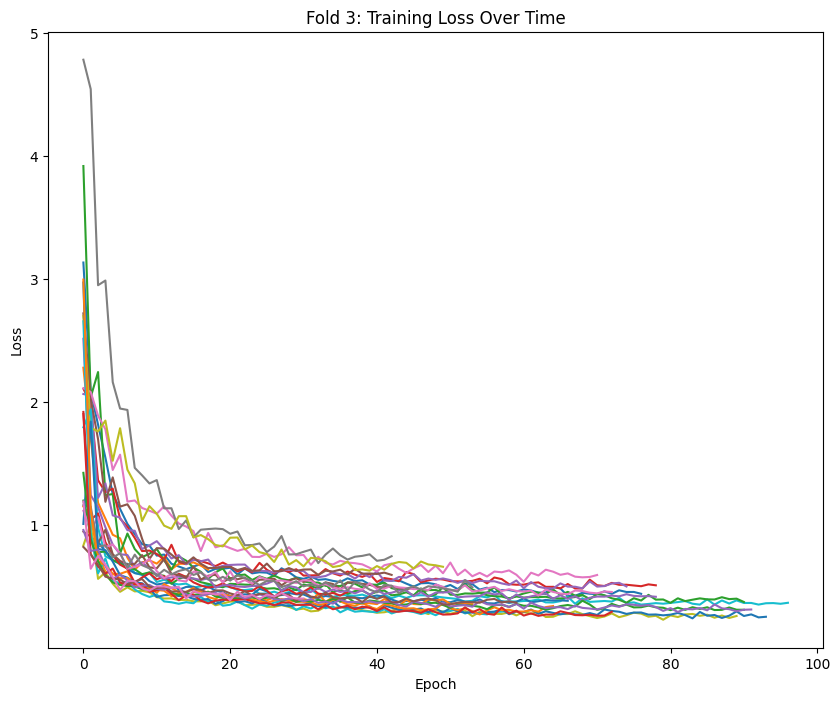

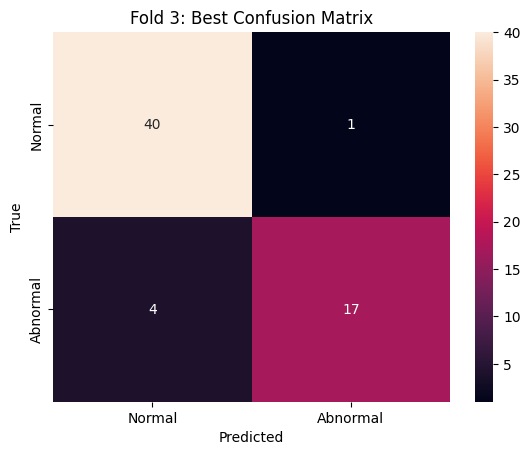

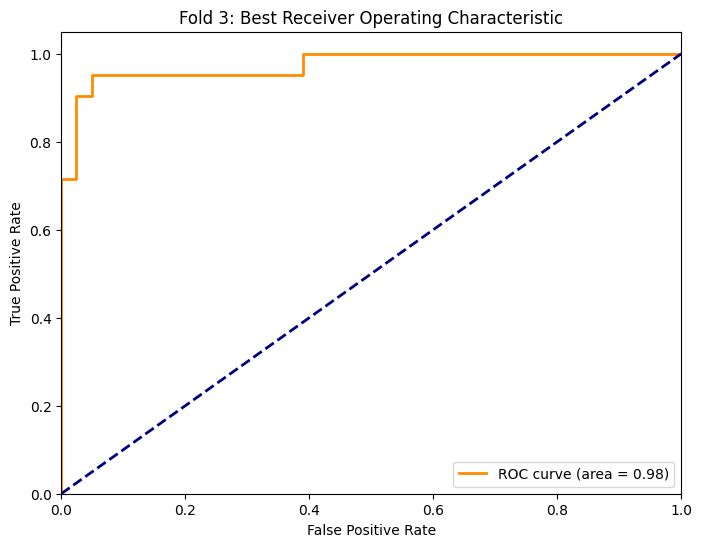

Fold 4/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 94
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 75
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 56
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 103
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 36
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 40
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 44
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 45
(9) Training with params: weight_decay = 1e-06, learning_

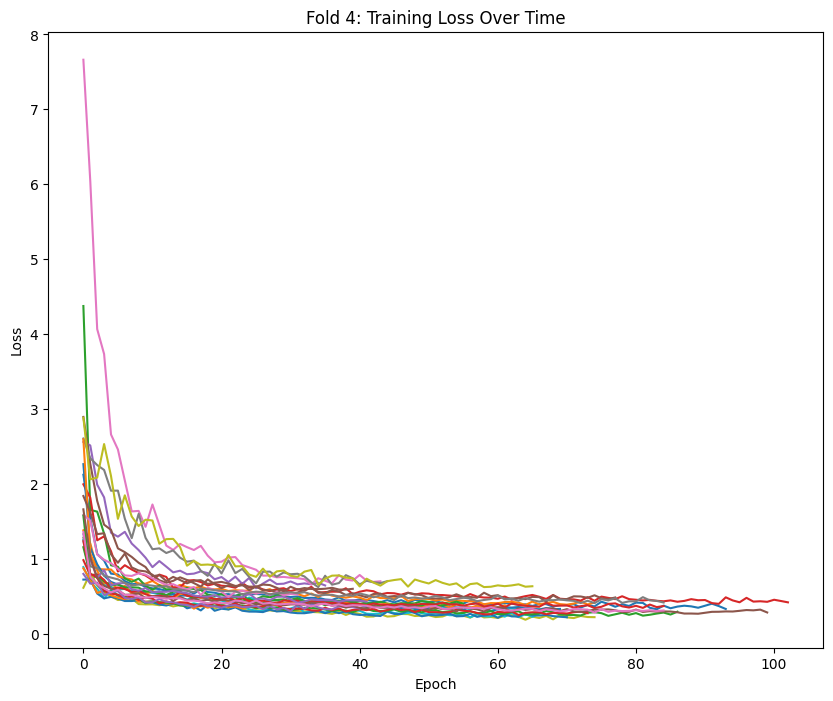

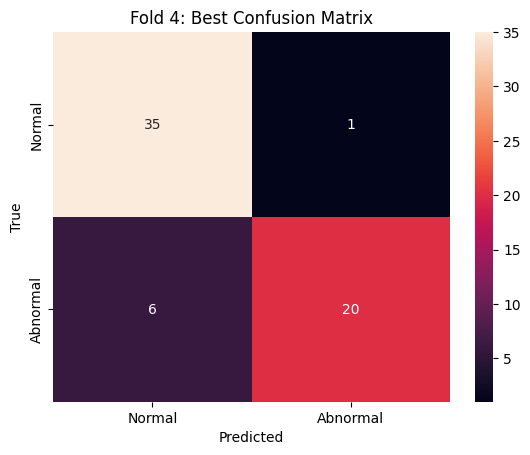

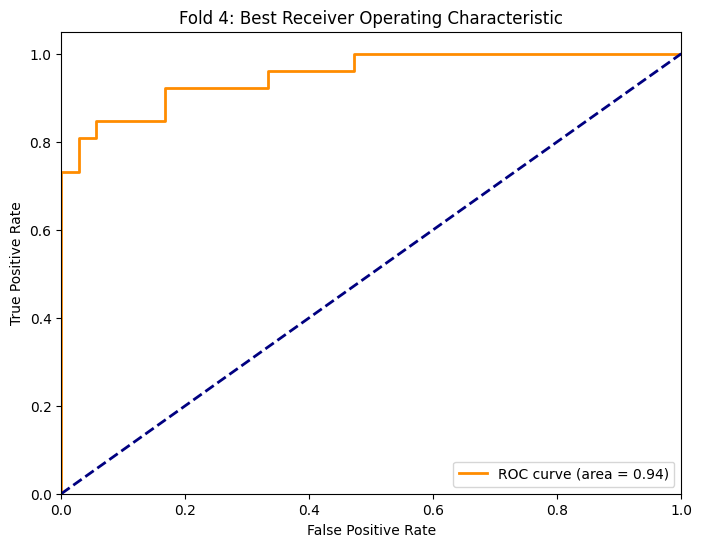

Fold 5/5
(1) Training with params: weight_decay = 0.0001, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 63
(2) Training with params: weight_decay = 1e-05, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 81
(3) Training with params: weight_decay = 1e-06, learning_rate = 0.002, dropout = 0.5
    Early stopping at epoch 65
(4) Training with params: weight_decay = 0.0001, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 87
(5) Training with params: weight_decay = 1e-05, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 92
(6) Training with params: weight_decay = 1e-06, learning_rate = 0.001, dropout = 0.5
    Early stopping at epoch 94
(7) Training with params: weight_decay = 0.0001, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 63
(8) Training with params: weight_decay = 1e-05, learning_rate = 0.0005, dropout = 0.5
    Early stopping at epoch 41
(9) Training with params: weight_decay = 1e-06, learning_r

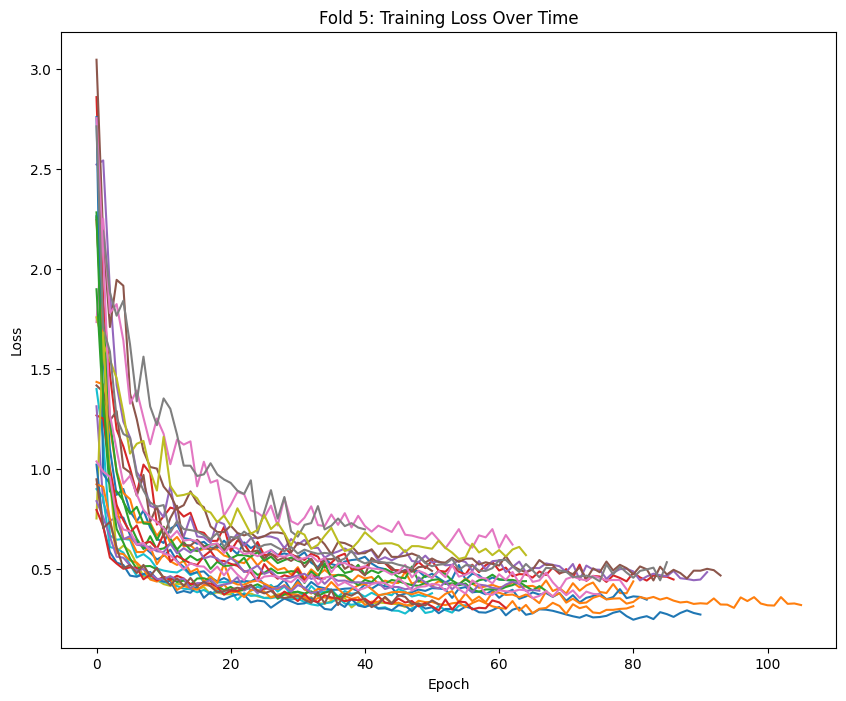

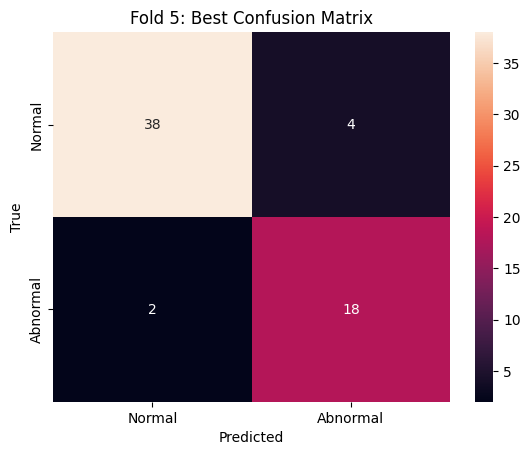

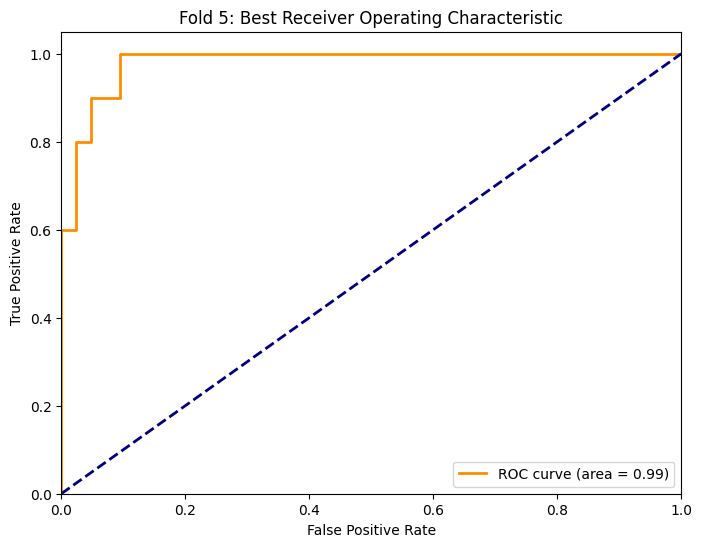

In [9]:
# Define the number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits = k_folds, shuffle = True, random_state = 42)

# Initialize metrics to collect results from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
roc_aucs = []

param_grid = {
    'learning_rate': [0.002, 0.001, 0.0005],
    'weight_decay': [1e-4, 1e-5, 1e-6],
    'dropout': [0.5, 0.3, 0.1]
}

# Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(node_features)):
    print(f'Fold {fold + 1}/{k_folds}')

    # Create lists to hold the results for plotting
    Count = 1
    loss_values_folds = []
    confusion_matrices = []
    roc_curves = []
    
    # Split data
    X_train, X_test = node_features[train_index], node_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # Create Data objects for training and testing sets
    train_data = create_graph_data(X_train, y_train)
    test_data = create_graph_data(X_test, y_test)
    
    # Create DataLoader instances
    train_loader = GeometricDataLoader([train_data], batch_size = 1, shuffle = True)
    test_loader = GeometricDataLoader([test_data], batch_size = 1, shuffle = False)

    best_params = None
    best_fold_metrics = None
    best_fold_loss = float('inf')


    # Iterate over parameter combinations
    for params in ParameterGrid(param_grid):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        dropout = params['dropout']

        # Print the parameters being used
        print(f'({Count}) Training with params: weight_decay = {weight_decay}, learning_rate = {learning_rate}, dropout = {dropout}')
    
        # Initialize the model with the current set of parameters
        model = AdvancedGNNModel(num_node_features = 12, num_classes = 2, dropout = dropout)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
        criterion = torch.nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.9)
    
        # Train the model with early stopping
        epochs = 200
        early_stopping_patience = 10
        best_loss = float('inf')
        patience_counter = 0
        loss_values = []
        
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, batch.y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2.0)
                optimizer.step()
                epoch_loss += loss.item()
            scheduler.step()
            loss_values.append(epoch_loss / len(train_loader))
            
            # Early stopping
            epoch_loss /= len(train_loader)
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"    Early stopping at epoch {epoch+1}")
                    Count = Count + 1
                    break

        # Save the loss values for this fold
        loss_values_folds.append(loss_values)
        
        # Evaluate the model
        model.eval()
        true_labels = []
        predictions = []
        probs = []
        
        with torch.no_grad():
            for batch in test_loader:
                out = model(batch)
                _, pred = out.max(dim = 1)
                predictions.extend(pred.tolist())
                true_labels.extend(batch.y.tolist())
                probs.extend(F.softmax(out, dim = 1)[:, 1].tolist())
         
        # Convert lists to numpy arrays for metric calculation
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)
        probs = np.array(probs)
        
        # Calculate metrics
        test_accuracy = accuracy_score(true_labels, predictions)
        test_precision = precision_score(true_labels, predictions, average = 'macro', zero_division = 0)
        test_recall = recall_score(true_labels, predictions, average = 'macro', zero_division = 0)
        test_f1 = f1_score(true_labels, predictions, average = 'macro', zero_division = 0)
        fpr, tpr, _ = roc_curve(true_labels, probs)
        test_roc_auc = auc(fpr, tpr)

        # Check if this parameter combination is the best for this fold
        if best_loss < best_fold_loss:
            best_fold_loss = best_loss
            best_params = params
            best_true_labels = true_labels
            best_predictions = predictions
            best_probs = probs
            best_fold_metrics = {
                'accuracy': test_accuracy,
                'precision': test_precision,
                'recall': test_recall,
                'f1': test_f1,
                'roc_auc': test_roc_auc
            }
    
    # Collect metrics for this fold
    accuracies.append(best_fold_metrics['accuracy'])
    precisions.append(best_fold_metrics['precision'])
    recalls.append(best_fold_metrics['recall'])
    f1s.append(best_fold_metrics['f1'])
    roc_aucs.append(best_fold_metrics['roc_auc'])

    print(f'Fold {fold + 1} - Best Params: {best_params}')
    print(f'Fold {fold + 1} - Accuracy: {best_fold_metrics["accuracy"]:.4f}, Precision: {best_fold_metrics["precision"]:.4f}, Recall: {best_fold_metrics["recall"]:.4f}, F1 Score: {best_fold_metrics["f1"]:.4f}, ROC AUC: {best_fold_metrics["roc_auc"]:.4f}')

    plt.figure(figsize = (10, 8))
    for loss_values in loss_values_folds:
        plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold + 1}: Training Loss Over Time')
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(best_true_labels, best_predictions)
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['Normal', 'Abnormal'], yticklabels = ['Normal', 'Abnormal'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {fold + 1}: Best Confusion Matrix')
    plt.show()

    # Plot ROC curve and calculate AUC
    best_fpr, best_tpr, _ = roc_curve(best_true_labels, best_probs)
    best_roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(best_fpr, best_tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {best_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Fold {fold + 1}: Best Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
print(f'\nCross-Validation Results:')
# Print overall metrics
print(f'Overall Metrics:')
print(f'Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')
print(f'Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}')
print(f'Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}')
print(f'F1 Score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}')
print(f'ROC AUC: {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}')


Cross-Validation Results:
Overall Metrics:
Accuracy: 0.9194 ± 0.0228
Precision: 0.9231 ± 0.0268
Recall: 0.8955 ± 0.0170
F1 Score: 0.9054 ± 0.0182
ROC AUC: 0.9786 ± 0.0158


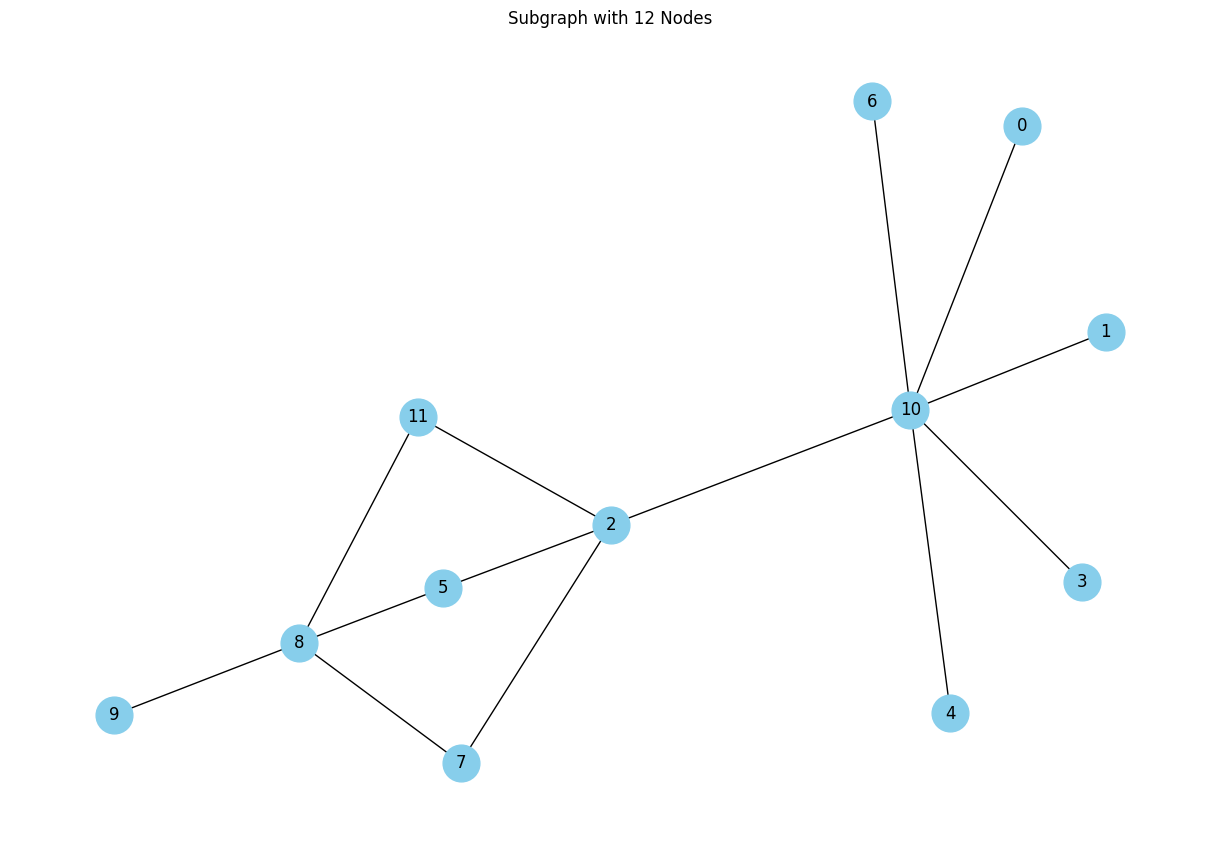

In [11]:
# Visualize subgraph
visualize_graph(create_custom_edge_index(), num_nodes = 12)

Training GAN for evaluation

In [12]:
# Define GAN components: Generator and Discriminator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, output_dim),
            nn.Sigmoid()  # assuming output data is normalized to [0, 1]
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [13]:
# Hyperparameters
latent_dim = 32
batch_size = 64
lr = 0.0002
num_epochs = 100

# Define generator and discriminator
generator = Generator(latent_dim, X_train.shape[1])
discriminator = Discriminator(X_train.shape[1])

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
adversarial_loss = nn.BCELoss()

# Create DataLoader for training the GAN
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training the GAN
for epoch in range(num_epochs):
    for i, (real_data,) in enumerate(train_loader):
        batch_size = real_data.size(0)
        
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1)
        fake = torch.zeros(batch_size, 1)

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(batch_size, latent_dim)

        # Generate a batch of data
        gen_data = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_data), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_data), valid)
        fake_loss = adversarial_loss(discriminator(gen_data.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch + 1}/{num_epochs} - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

print("GAN training complete.")

Epoch 1/100 - D Loss: 0.3220, G Loss: 0.7474
Epoch 2/100 - D Loss: 0.3019, G Loss: 0.7958
Epoch 3/100 - D Loss: 0.2835, G Loss: 0.8404
Epoch 4/100 - D Loss: 0.2659, G Loss: 0.8871
Epoch 5/100 - D Loss: 0.2504, G Loss: 0.9327
Epoch 6/100 - D Loss: 0.2355, G Loss: 0.9814
Epoch 7/100 - D Loss: 0.2214, G Loss: 1.0293
Epoch 8/100 - D Loss: 0.2076, G Loss: 1.0806
Epoch 9/100 - D Loss: 0.1955, G Loss: 1.1306
Epoch 10/100 - D Loss: 0.1857, G Loss: 1.1758
Epoch 11/100 - D Loss: 0.1746, G Loss: 1.2274
Epoch 12/100 - D Loss: 0.1670, G Loss: 1.2633
Epoch 13/100 - D Loss: 0.1607, G Loss: 1.2936
Epoch 14/100 - D Loss: 0.1524, G Loss: 1.3407
Epoch 15/100 - D Loss: 0.1492, G Loss: 1.3566
Epoch 16/100 - D Loss: 0.1447, G Loss: 1.3933
Epoch 17/100 - D Loss: 0.1379, G Loss: 1.4297
Epoch 18/100 - D Loss: 0.1371, G Loss: 1.4294
Epoch 19/100 - D Loss: 0.1303, G Loss: 1.4873
Epoch 20/100 - D Loss: 0.1201, G Loss: 1.5462
Epoch 21/100 - D Loss: 0.1137, G Loss: 1.5935
Epoch 22/100 - D Loss: 0.1102, G Loss: 1.65

In [14]:
# Generate synthetic data
generator.eval()
with torch.no_grad():
    z = torch.randn(100, latent_dim)
    synthetic_data = generator(z)

# Create Data object for synthetic data
synthetic_labels = torch.cat([torch.zeros(50, dtype=torch.long), torch.ones(50, dtype=torch.long)])  # Balancing synthetic data
synthetic_data = create_graph_data(synthetic_data, synthetic_labels)

# Create DataLoader instance
synthetic_loader = GeometricDataLoader([synthetic_data], batch_size=1, shuffle=False)

# Use the trained GNN model directly (no need to save and load)
model.eval()

# Evaluate the model on synthetic data
synthetic_predictions = []
synthetic_probs = []

with torch.no_grad():
    for batch in synthetic_loader:
        out = model(batch)
        _, pred = out.max(dim=1)
        synthetic_predictions.extend(pred.tolist())
        synthetic_probs.extend(F.softmax(out, dim=1)[:, 1].tolist())

# Convert lists to numpy arrays for metric calculation
synthetic_predictions = np.array(synthetic_predictions)
synthetic_probs = np.array(synthetic_probs)

# Calculate metrics
synthetic_accuracy = accuracy_score(synthetic_labels, synthetic_predictions)
synthetic_precision = precision_score(synthetic_labels, synthetic_predictions, average='macro', zero_division=0)
synthetic_recall = recall_score(synthetic_labels, synthetic_predictions, average='macro', zero_division=0)
synthetic_f1 = f1_score(synthetic_labels, synthetic_predictions, average='macro', zero_division=0)
fpr, tpr, _ = roc_curve(synthetic_labels, synthetic_probs)
synthetic_roc_auc = auc(fpr, tpr)

print(f'Synthetic Data Accuracy: {synthetic_accuracy:.4f}')
print(f'Synthetic Data Precision: {synthetic_precision:.4f}')
print(f'Synthetic Data Recall: {synthetic_recall:.4f}')
print(f'Synthetic Data F1 Score: {synthetic_f1:.4f}')
print(f'Synthetic Data ROC AUC: {synthetic_roc_auc:.4f}')

Synthetic Data Accuracy: 0.5000
Synthetic Data Precision: 0.2500
Synthetic Data Recall: 0.5000
Synthetic Data F1 Score: 0.3333
Synthetic Data ROC AUC: 0.5136


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

# Define a function to train the VAE and return the average training loss
def train_vae(hidden_dim, latent_dim, lr, batch_size, num_epochs=100):
    vae = VAE(input_dim, hidden_dim, latent_dim)
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    
    train_dataset = TensorDataset(torch.tensor(X_train_normalized, dtype=torch.float))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    vae.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for data in train_loader:
            data = data[0]
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = vae.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
    
    return train_loss / len(train_loader.dataset)

In [16]:
# Hyperparameters
# Define the parameter grid
input_dim = X_train.shape[1]
param_grid = {
    'hidden_dim': [64, 128, 256],
    'latent_dim': [32, 64, 128],
    'lr': [0.001, 0.0005],
    'batch_size': [32, 64]
}

# Normalize the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)

# Perform grid search
best_params = None
best_loss = float('inf')
for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")
    avg_loss = train_vae(params['hidden_dim'], params['latent_dim'], params['lr'], params['batch_size'])
    print(f"Average Loss: {avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"Best params: {best_params}, Best Loss: {best_loss:.4f}")


# Use the best parameters to train the final VAE model
hidden_dim = best_params['hidden_dim']
latent_dim = best_params['latent_dim']
lr = best_params['lr']
batch_size = best_params['batch_size']

# Define VAE with best parameters
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Create DataLoader for training the VAE
train_dataset = TensorDataset(torch.tensor(X_train_normalized, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training the VAE
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for data in train_loader:
        data = data[0]
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae.loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}')

print("VAE training complete.")

Training with params: {'batch_size': 32, 'hidden_dim': 64, 'latent_dim': 32, 'lr': 0.001}
Average Loss: 7.7305
Training with params: {'batch_size': 32, 'hidden_dim': 64, 'latent_dim': 32, 'lr': 0.0005}
Average Loss: 7.7359
Training with params: {'batch_size': 32, 'hidden_dim': 64, 'latent_dim': 64, 'lr': 0.001}
Average Loss: 7.7279
Training with params: {'batch_size': 32, 'hidden_dim': 64, 'latent_dim': 64, 'lr': 0.0005}
Average Loss: 7.7325
Training with params: {'batch_size': 32, 'hidden_dim': 64, 'latent_dim': 128, 'lr': 0.001}
Average Loss: 7.7273
Training with params: {'batch_size': 32, 'hidden_dim': 64, 'latent_dim': 128, 'lr': 0.0005}
Average Loss: 7.7415
Training with params: {'batch_size': 32, 'hidden_dim': 128, 'latent_dim': 32, 'lr': 0.001}
Average Loss: 7.7310
Training with params: {'batch_size': 32, 'hidden_dim': 128, 'latent_dim': 32, 'lr': 0.0005}
Average Loss: 7.7324
Training with params: {'batch_size': 32, 'hidden_dim': 128, 'latent_dim': 64, 'lr': 0.001}
Average Loss:

In [17]:
# Generate synthetic data
vae.eval()
with torch.no_grad():
    z = torch.randn(100, latent_dim)
    synthetic_data = vae.decode(z).cpu().numpy()

# Convert synthetic data back to original scale
synthetic_data = scaler.inverse_transform(synthetic_data)
synthetic_data = torch.tensor(synthetic_data, dtype=torch.float)
synthetic_labels = torch.cat([torch.zeros(50, dtype=torch.long), torch.ones(50, dtype=torch.long)])  # Balancing synthetic data

# Create Data object for synthetic data
synthetic_graph_data = create_graph_data(synthetic_data, synthetic_labels)

# Create DataLoader instance
synthetic_loader = GeometricDataLoader([synthetic_graph_data], batch_size=1, shuffle=False)

# Use the trained GNN model directly (no need to save and load)
model.eval()

# Evaluate the model on synthetic data
synthetic_predictions = []
synthetic_probs = []

with torch.no_grad():
    for batch in synthetic_loader:
        out = model(batch)
        _, pred = out.max(dim=1)
        synthetic_predictions.extend(pred.tolist())
        synthetic_probs.extend(F.softmax(out, dim=1)[:, 1].tolist())

# Convert lists to numpy arrays for metric calculation
synthetic_predictions = np.array(synthetic_predictions)
synthetic_probs = np.array(synthetic_probs)

# Calculate metrics
synthetic_accuracy = accuracy_score(synthetic_labels, synthetic_predictions)
synthetic_precision = precision_score(synthetic_labels, synthetic_predictions, average='macro', zero_division=0)
synthetic_recall = recall_score(synthetic_labels, synthetic_predictions, average='macro', zero_division=0)
synthetic_f1 = f1_score(synthetic_labels, synthetic_predictions, average='macro', zero_division=0)
fpr, tpr, _ = roc_curve(synthetic_labels, synthetic_probs)
synthetic_roc_auc = auc(fpr, tpr)

print(f'Synthetic Data Accuracy: {synthetic_accuracy:.4f}')
print(f'Synthetic Data Precision: {synthetic_precision:.4f}')
print(f'Synthetic Data Recall: {synthetic_recall:.4f}')
print(f'Synthetic Data F1 Score: {synthetic_f1:.4f}')
print(f'Synthetic Data ROC AUC: {synthetic_roc_auc:.4f}')

Synthetic Data Accuracy: 0.5000
Synthetic Data Precision: 0.5000
Synthetic Data Recall: 0.5000
Synthetic Data F1 Score: 0.4430
Synthetic Data ROC AUC: 0.5660


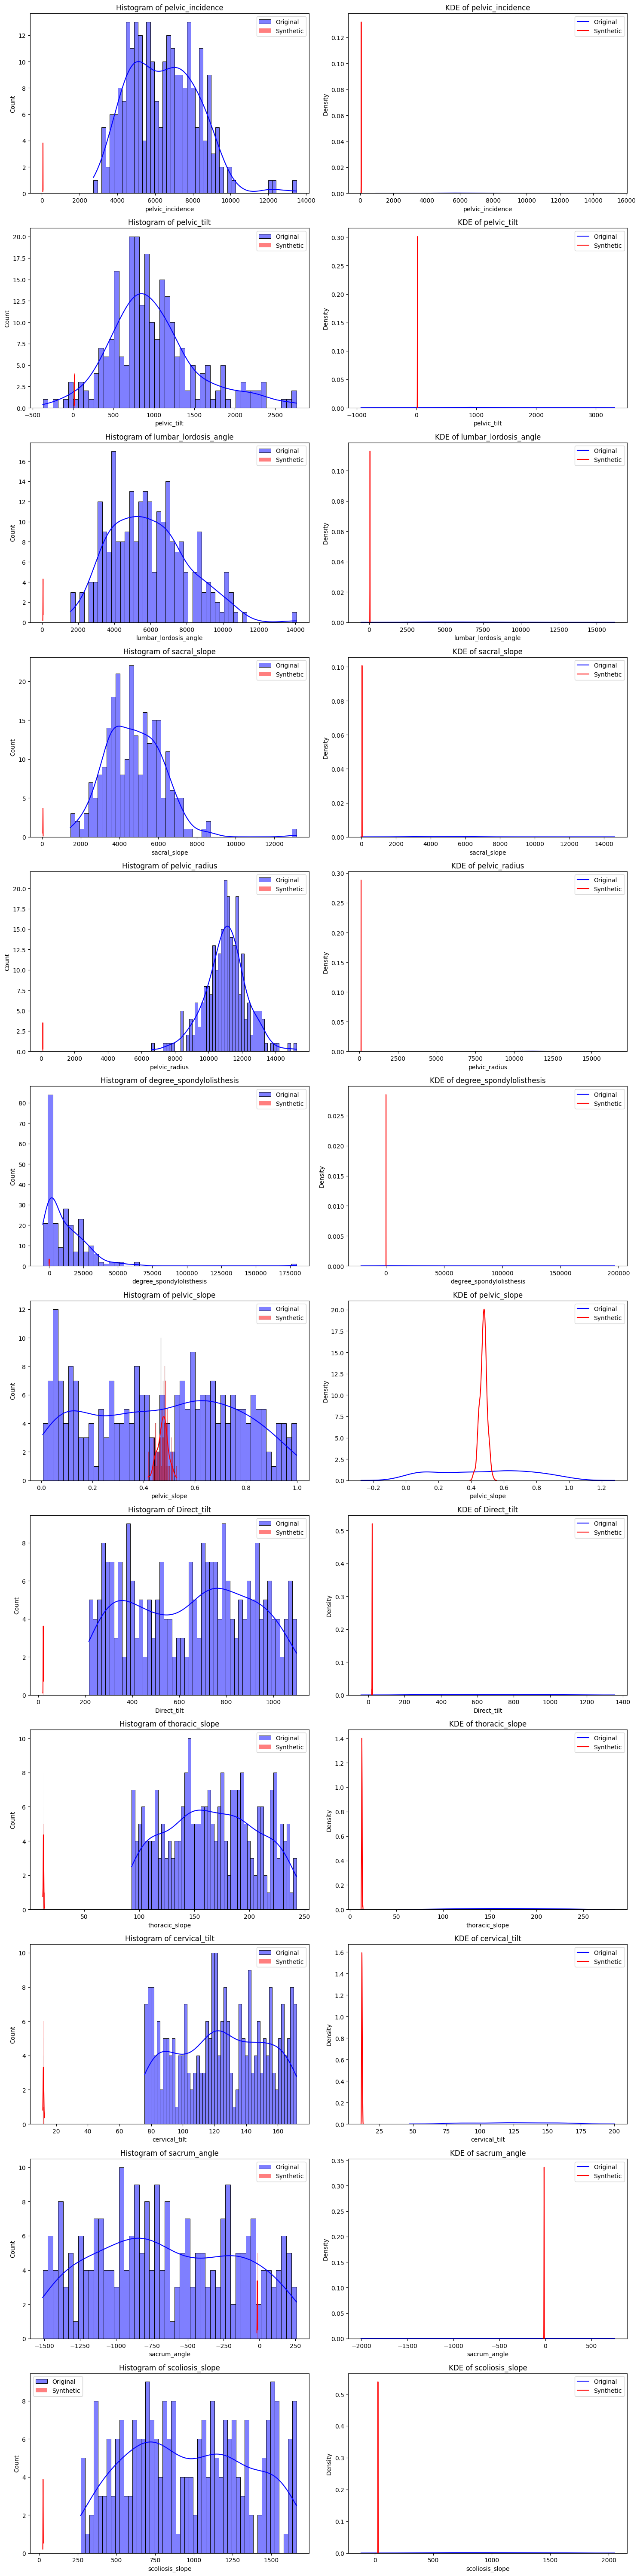

In [18]:
# Convert to DataFrame for easier plotting
original_df = pd.DataFrame(scaler.inverse_transform(X_train.numpy()), columns=["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius",
                                                                              "degree_spondylolisthesis", "pelvic_slope", "Direct_tilt", "thoracic_slope", "cervical_tilt",
                                                                              "sacrum_angle", "scoliosis_slope"])
synthetic_df = pd.DataFrame(synthetic_data.numpy(), columns=original_df.columns)

# Plot histograms and KDEs for each feature
num_features = original_df.shape[1]
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(15, num_features*5))

for i, column in enumerate(original_df.columns):
    # Histogram
    sns.histplot(original_df[column], bins=50, color='blue', label='Original', ax=axes[i, 0], kde=True)
    sns.histplot(synthetic_df[column], bins=50, color='red', label='Synthetic', ax=axes[i, 0], kde=True)
    axes[i, 0].set_title(f'Histogram of {column}')
    axes[i, 0].legend()

    # KDE
    sns.kdeplot(original_df[column], color='blue', label='Original', ax=axes[i, 1])
    sns.kdeplot(synthetic_df[column], color='red', label='Synthetic', ax=axes[i, 1])
    axes[i, 1].set_title(f'KDE of {column}')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [19]:
# Visualize the original and synthetic data
def plot_distribution(X_original, y_original, X_synthetic, y_synthetic):
    features = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius",
                "degree_spondylolisthesis", "pelvic_slope", "Direct_tilt", "thoracic_slope", "cervical_tilt",
                "sacrum_angle", "scoliosis_slope"]
    
    fig, axs = plt.subplots(len(features), 2, figsize=(15, 30))

    for i, feature in enumerate(features):
        sns.histplot(X_original[:, i], kde=True, color='blue', label='Original', ax=axs[i, 0])
        sns.histplot(X_synthetic[:, i], kde=True, color='red', label='Synthetic', ax=axs[i, 0])
        axs[i, 0].set_title(f'Histogram of {feature}')
        axs[i, 0].legend()
        
        sns.kdeplot(X_original[:, i], color='blue', label='Original', ax=axs[i, 1])
        sns.kdeplot(X_synthetic[:, i], color='red', label='Synthetic', ax=axs[i, 1])
        axs[i, 1].set_title(f'KDE of {feature}')
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

# Generate synthetic data by averaging a given number of samples
def create_averaged_data(X, y, window_size):
    n_samples = X.shape[0] // window_size
    X_averaged = np.array([X[i*window_size:(i+1)*window_size].mean(axis=0) for i in range(n_samples)])
    y_averaged = np.array([np.bincount(y[i*window_size:(i+1)*window_size]).argmax() for i in range(n_samples)])
    return X_averaged, y_averaged

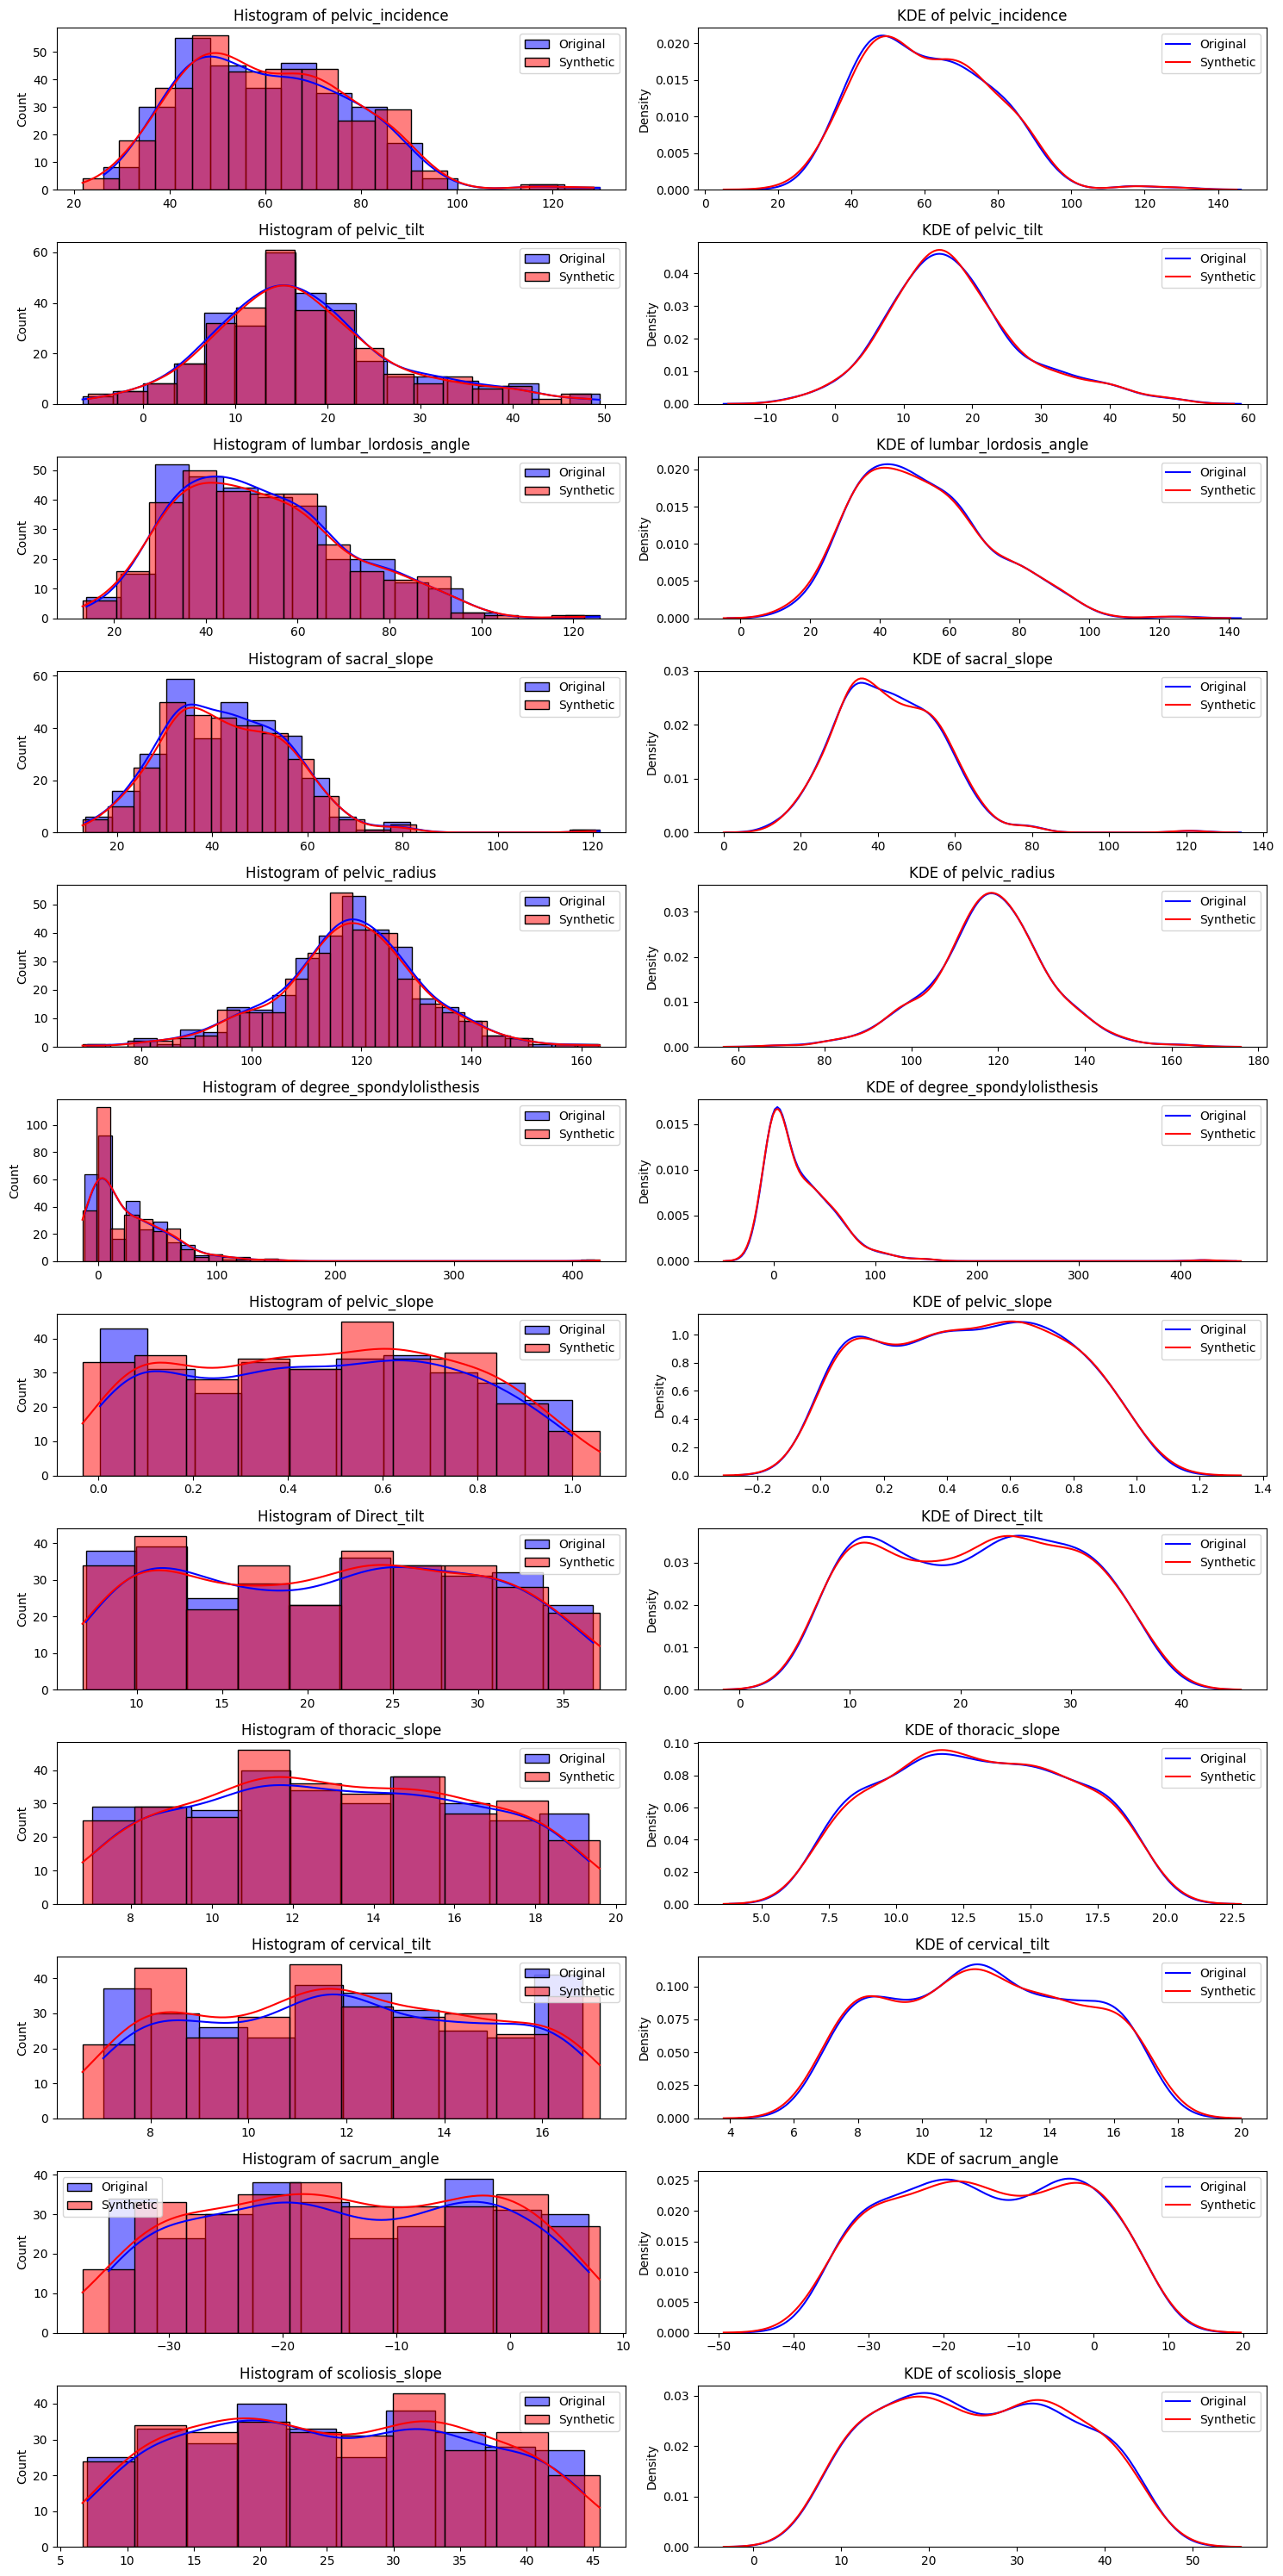

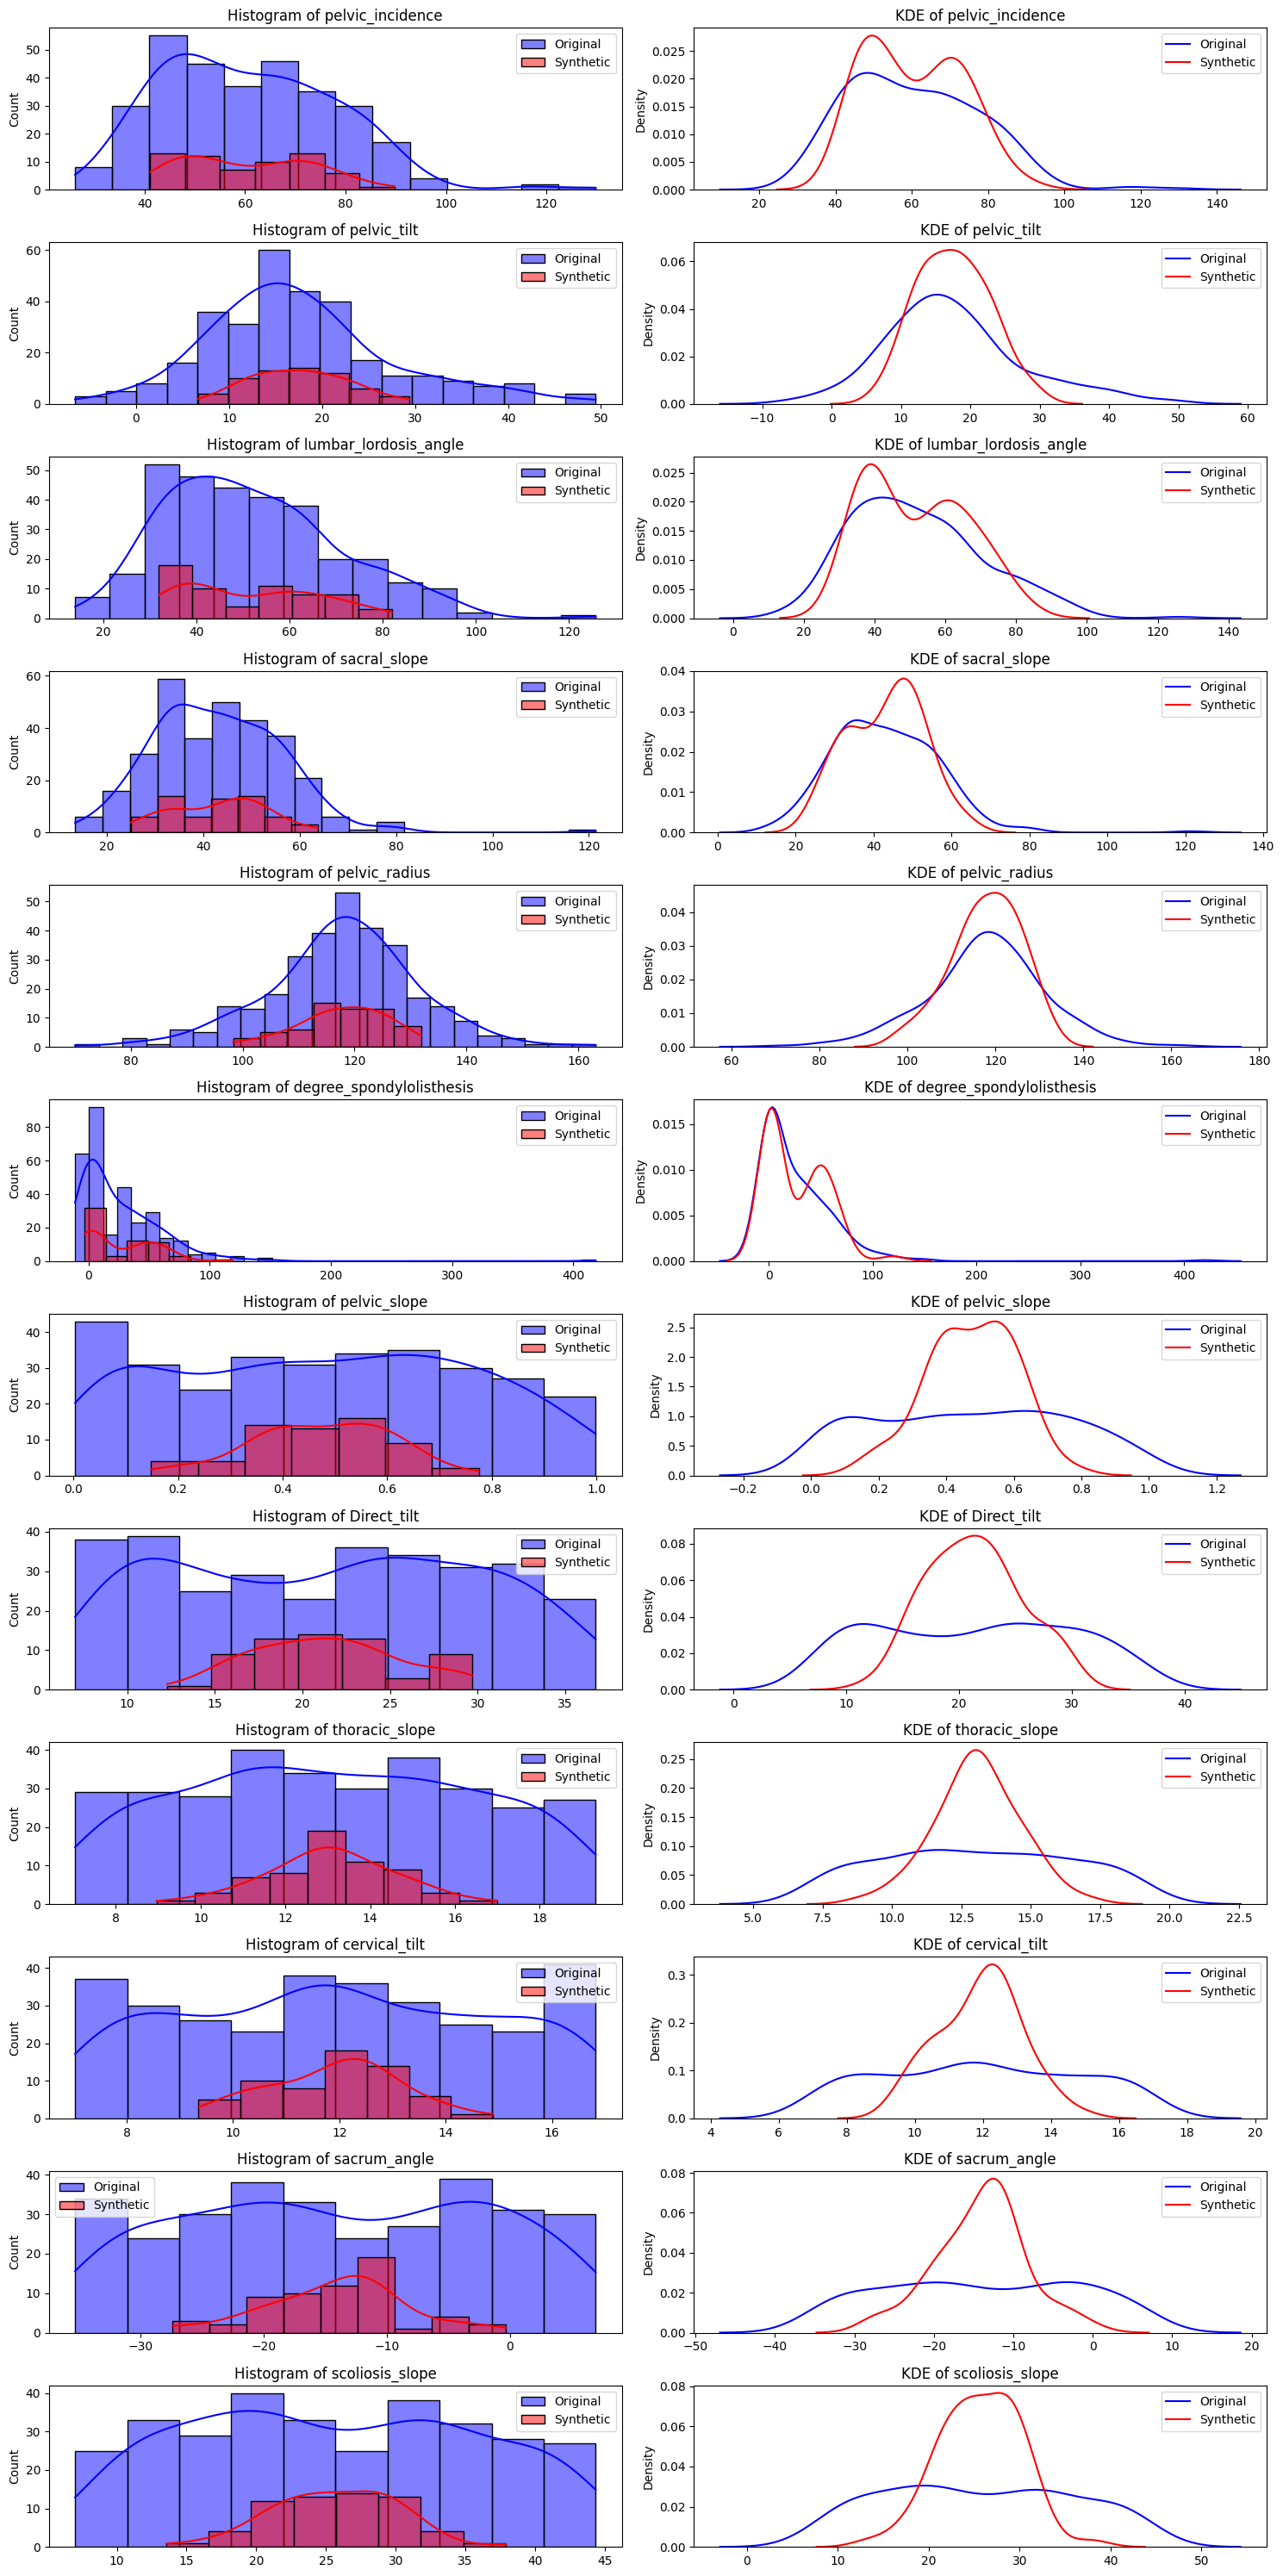

In [20]:
# Normalize the data
scaler = StandardScaler()
node_features_scaled = scaler.fit_transform(node_features)

# Generate synthetic data by adding Gaussian noise
noise_factor = 0.1
data_synthetic_scaled_noise = node_features_scaled + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=node_features_scaled.shape)
data_synthetic_noise = scaler.inverse_transform(data_synthetic_scaled_noise)

# Set the window size for averaging
window_size = 5
data_synthetic_scaled_average, labels_synthetic_average = create_averaged_data(data_synthetic_scaled_noise, labels, window_size)
data_synthetic_average = scaler.inverse_transform(data_synthetic_scaled_average)

plot_distribution(node_features, labels, data_synthetic_noise, labels)
plot_distribution(node_features, labels, data_synthetic_average, labels_synthetic_average)

Synthetic Data Accuracy: 1.0000
Synthetic Data Precision: 1.0000
Synthetic Data Recall: 1.0000
Synthetic Data F1 Score: 1.0000
Synthetic Data ROC AUC: 1.0000


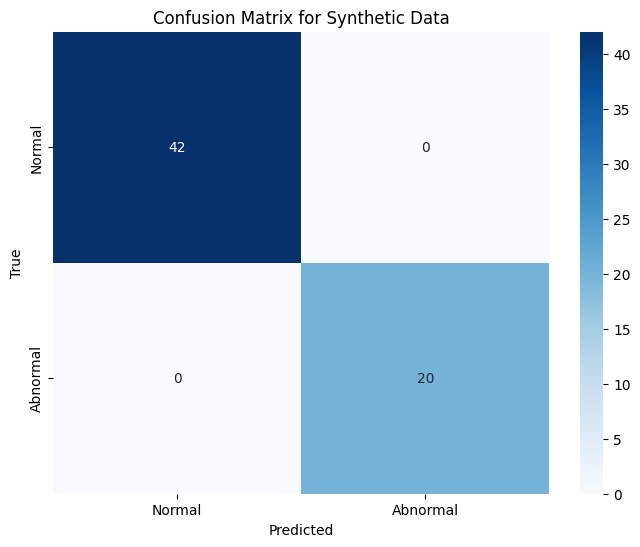

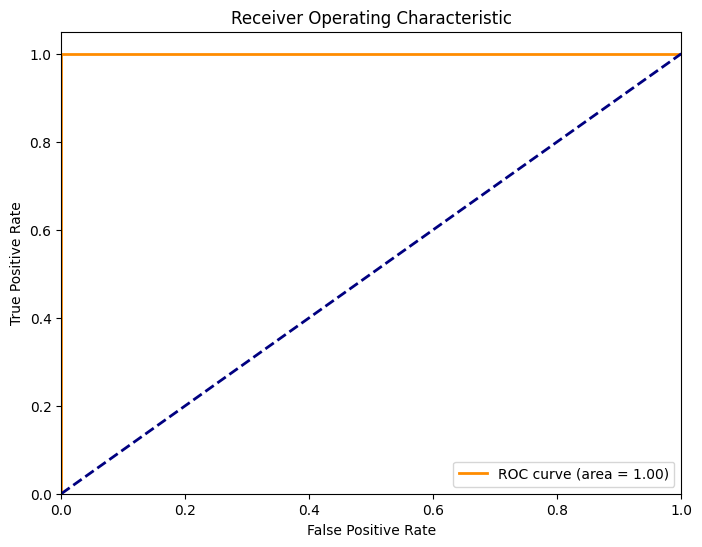

In [21]:
# Convert to PyTorch tensors
synthetic_data_tensor = torch.tensor(data_synthetic_average, dtype=torch.float)
synthetic_labels_tensor = torch.tensor(labels_synthetic_average, dtype=torch.long)

# Create Data object for combined data
synthetic_graph_data = create_graph_data(synthetic_data_tensor, synthetic_labels_tensor)

# Create DataLoader instance
synthetic_data_loader = GeometricDataLoader([synthetic_graph_data], batch_size=1, shuffle=False)

model.eval()

# Evaluate the model with combined data
synthetic_predictions = []
synthetic_probs = []

with torch.no_grad():
    for batch in synthetic_data_loader:
        output = model(batch)
        _, pred = output.max(dim=1)
        synthetic_predictions.extend(pred.tolist())
        synthetic_probs.extend(torch.softmax(output, dim=1)[:, 1].tolist())

# Convert lists to numpy arrays for metric calculation
synthetic_predictions = np.array(synthetic_predictions)
synthetic_probs = np.array(synthetic_probs)

# Calculate metrics
synthetic_accuracy = accuracy_score(labels_synthetic_average, synthetic_predictions)
synthetic_precision = precision_score(labels_synthetic_average, synthetic_predictions, average='macro', zero_division=0)
synthetic_recall = recall_score(labels_synthetic_average, synthetic_predictions, average='macro', zero_division=0)
synthetic_f1 = f1_score(labels_synthetic_average, synthetic_predictions, average='macro', zero_division=0)
fpr, tpr, _ = roc_curve(labels_synthetic_average, synthetic_probs)
synthetic_roc_auc = auc(fpr, tpr)

print(f'Synthetic Data Accuracy: {synthetic_accuracy:.4f}')
print(f'Synthetic Data Precision: {synthetic_precision:.4f}')
print(f'Synthetic Data Recall: {synthetic_recall:.4f}')
print(f'Synthetic Data F1 Score: {synthetic_f1:.4f}')
print(f'Synthetic Data ROC AUC: {synthetic_roc_auc:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(labels_synthetic_average, synthetic_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Synthetic Data')
plt.show()

# Plot ROC curve and calculate AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {synthetic_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()